# PSO-Enhanced RBF Modelling – single station
This notebook covers modelling & evaluation for **one** aviation station:

* feature engineering  
* baseline RBF vs PSO-RBF  
* RMSE / MAE / MAPE / KGE + significance (Diebold–Mariano)  
* permutation importance for research question 2


In [1]:
from pathlib import Path
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from scipy import stats
import pyswarms as ps, warnings ; warnings.filterwarnings("ignore")

# ── EDIT ONLY THESE TWO LINES WHEN YOU CHANGE STATION ── #
STATION_ID = "97230"
DATA_FILE  = Path(f"/home/rzby/airpressure_ann/ann_pressure_prediction/data/processed/clean_{STATION_ID}.parquet")
# ──────────────────────────────────────────────────────── #

SEED = 42


In [2]:
def add_time_feats(df):
    ang_h = 2*np.pi*df.index.hour/24
    ang_d = 2*np.pi*df.index.dayofyear/365.25
    df["sin_hour"], df["cos_hour"] = np.sin(ang_h), np.cos(ang_h)
    df["sin_doy"],  df["cos_doy"]  = np.sin(ang_d), np.cos(ang_d)
    return df

def add_lags(df, cols, lags=[1,2,4]):
    for c in cols:
        for k in lags:
            df[f"{c}_lag{k}"] = df[c].shift(k)
    return df

def kge(y, yhat):
    r = np.corrcoef(y, yhat)[0,1]
    alpha = yhat.std()/y.std()
    beta  = yhat.mean()/y.mean()
    return 1-np.sqrt((r-1)**2+(alpha-1)**2+(beta-1)**2)

from sklearn.cluster import MiniBatchKMeans
from numpy.linalg import pinv
import numpy as np

class RBFNetwork:
    """
    Radial-Basis-Function Neural Network with:
      • K centres from (MiniBatch) K-means
      • Gaussian basis ϕ(||x−c||)  with shared gamma
      • Closed-form ridge regression for output weights
    """
    def __init__(self, n_centres=300, gamma=None,
                 ridge=1e-4, random_state=42, batch_size=1024):
        self.n_centres  = n_centres
        self.gamma      = gamma        # if None compute from centres spread
        self.ridge      = ridge
        self.rs         = random_state
        self.batch_size = batch_size   # for MiniBatchKMeans

    # ───────────────── helpers ──────────────────
    @staticmethod
    def _euclid(a,b):
        return np.linalg.norm(a[:,None,:] - b[None,:,:], axis=2)

    def _rbf(self, X):
        d = self._euclid(X, self.C_)
        return np.exp(-(self.gamma * d**2))

    # ─────────────── public API ─────────────────
    def fit(self, X, y):
        # 1) choose K centres
        km = MiniBatchKMeans(n_clusters=self.n_centres,
                             random_state=self.rs,
                             batch_size=self.batch_size)
        km.fit(X)
        self.C_ = km.cluster_centers_

        # 2) set gamma if not user-supplied
        if self.gamma is None:
            d_max = np.max(self._euclid(self.C_, self.C_))
            sigma = d_max / np.sqrt(2*self.n_centres)
            self.gamma = 1 / (2*sigma**2)

        # 3) hidden matrix
        H = self._rbf(X)

        # 4) ridge regression: β = (HᵀH + λI)⁻¹ Hᵀ y
        I = self.ridge * np.eye(self.n_centres)
        self.B_ = pinv(H.T @ H + I) @ H.T @ y
        return self

    def predict(self, X):
        return self._rbf(X) @ self.B_



In [3]:
df = pd.read_parquet(DATA_FILE).set_index('index')
df.head()

,WMO_ID,RAINFALL_LAST_MM,TEMP_DEWPOINT_C_TDTDTD,TEMP_DRYBULB_C_TTTTTT,TEMP_WETBULB_C,WIND_SPEED_FF,RELATIVE_HUMIDITY_PC,PRESSURE_QFF_MB_DERIVED,PRESSURE_QFE_MB_DERIVED,month
index,,,,,,,,,,
2015-01-01 00:00:00+00:00,97230,-0.999845,0.342466,-0.085714,0.147059,0.176471,0.189448,1008.3,1007.8,-1.0
2015-01-01 03:00:00+00:00,97230,-1.000000,0.397260,0.257143,0.323529,0.411765,-0.165468,1008.0,1007.5,-1.0
2015-01-01 06:00:00+00:00,97230,-0.831008,0.150685,-0.580952,-0.205882,-0.764706,0.654676,1006.2,1005.7,-1.0
2015-01-01 09:00:00+00:00,97230,-0.996899,0.506849,0.200000,0.382353,0.411765,-0.016787,1005.4,1004.9,-1.0
2015-01-01 12:00:00+00:00,97230,-1.000000,0.205479,-0.085714,0.029412,-0.176471,0.055156,1008.0,1007.5,-1.0


In [4]:

# feature engineering
df = add_time_feats(df)
core = ["PRESSURE_QFF_MB_DERIVED","PRESSURE_QFE_MB_DERIVED","TEMP_DEWPOINT_C_TDTDTD","TEMP_DRYBULB_C_TTTTTT", "TEMP_WETBULB_C", "WIND_SPEED_FF","RAINFALL_LAST_MM", "RELATIVE_HUMIDITY_PC"]
df = add_lags(df, core, lags=[1,2,4]).dropna()
df.head()

,WMO_ID,RAINFALL_LAST_MM,TEMP_DEWPOINT_C_TDTDTD,TEMP_DRYBULB_C_TTTTTT,TEMP_WETBULB_C,WIND_SPEED_FF,RELATIVE_HUMIDITY_PC,PRESSURE_QFF_MB_DERIVED,PRESSURE_QFE_MB_DERIVED,month,...,TEMP_WETBULB_C_lag4,WIND_SPEED_FF_lag1,WIND_SPEED_FF_lag2,WIND_SPEED_FF_lag4,RAINFALL_LAST_MM_lag1,RAINFALL_LAST_MM_lag2,RAINFALL_LAST_MM_lag4,RELATIVE_HUMIDITY_PC_lag1,RELATIVE_HUMIDITY_PC_lag2,RELATIVE_HUMIDITY_PC_lag4
index,,,,,,,,,,,,,,,,,,,,,
2015-01-01 12:00:00+00:00,97230,-1.000000,0.205479,-0.085714,0.029412,-0.176471,0.055156,1008.0,1007.5,-1.0,...,0.147059,0.411765,-0.764706,0.176471,-0.996899,-0.831008,-0.999845,-0.016787,0.654676,0.189448
2015-01-01 15:00:00+00:00,97230,-0.999845,0.150685,-0.238095,-0.058824,-0.176471,0.208633,1009.3,1008.8,-1.0,...,0.323529,-0.176471,0.411765,0.411765,-1.000000,-0.996899,-1.000000,0.055156,-0.016787,-0.165468
2015-01-01 18:00:00+00:00,97230,-1.000000,0.424658,-0.180952,0.176471,0.529412,0.386091,1006.9,1006.4,-1.0,...,-0.205882,-0.176471,-0.176471,-0.764706,-0.999845,-1.000000,-0.831008,0.208633,0.055156,0.654676
2015-01-01 21:00:00+00:00,97230,-1.000000,0.424658,-0.009524,0.235294,0.294118,0.160671,1006.3,1005.8,-1.0,...,0.382353,0.529412,-0.176471,0.411765,-1.000000,-0.999845,-0.996899,0.386091,0.208633,-0.016787
2015-01-02 00:00:00+00:00,97230,-0.987597,0.315068,-0.161905,0.088235,0.882353,0.251799,1009.0,1008.5,-1.0,...,0.029412,0.294118,0.529412,-0.176471,-1.000000,-1.000000,-1.000000,0.160671,0.386091,0.055156


In [5]:

# chronological 80 / 20 split
split = int(len(df)*0.8)
train, test = df.iloc[:split], df.iloc[split:]

y_tr, y_te = train["PRESSURE_QFE_MB_DERIVED"].values.astype('float32'), test["PRESSURE_QFE_MB_DERIVED"].values.astype('float32')
X_cols     = train.drop(columns=["PRESSURE_QFF_MB_DERIVED","PRESSURE_QFE_MB_DERIVED", "WMO_ID", "month"]).columns
print("Column for X: ", X_cols, len(X_cols))
X_tr       = train[X_cols].values.astype('float32')
X_te       = test[X_cols].values.astype('float32')


Column for X:  Index(['RAINFALL_LAST_MM', 'TEMP_DEWPOINT_C_TDTDTD', 'TEMP_DRYBULB_C_TTTTTT',
       'TEMP_WETBULB_C', 'WIND_SPEED_FF', 'RELATIVE_HUMIDITY_PC', 'sin_hour',
       'cos_hour', 'sin_doy', 'cos_doy', 'PRESSURE_QFF_MB_DERIVED_lag1',
       'PRESSURE_QFF_MB_DERIVED_lag2', 'PRESSURE_QFF_MB_DERIVED_lag4',
       'PRESSURE_QFE_MB_DERIVED_lag1', 'PRESSURE_QFE_MB_DERIVED_lag2',
       'PRESSURE_QFE_MB_DERIVED_lag4', 'TEMP_DEWPOINT_C_TDTDTD_lag1',
       'TEMP_DEWPOINT_C_TDTDTD_lag2', 'TEMP_DEWPOINT_C_TDTDTD_lag4',
       'TEMP_DRYBULB_C_TTTTTT_lag1', 'TEMP_DRYBULB_C_TTTTTT_lag2',
       'TEMP_DRYBULB_C_TTTTTT_lag4', 'TEMP_WETBULB_C_lag1',
       'TEMP_WETBULB_C_lag2', 'TEMP_WETBULB_C_lag4', 'WIND_SPEED_FF_lag1',
       'WIND_SPEED_FF_lag2', 'WIND_SPEED_FF_lag4', 'RAINFALL_LAST_MM_lag1',
       'RAINFALL_LAST_MM_lag2', 'RAINFALL_LAST_MM_lag4',
       'RELATIVE_HUMIDITY_PC_lag1', 'RELATIVE_HUMIDITY_PC_lag2',
       'RELATIVE_HUMIDITY_PC_lag4'],
      dtype='object') 34


In [6]:
rb_all = RBFNetwork(n_centres=300).fit(X_tr, y_tr)
pred_all = rb_all.predict(X_te)


In [7]:
pred_all_df = pd.DataFrame(pred_all, index=test.index)
pred_all_df.join(test['PRESSURE_QFE_MB_DERIVED']).to_csv(f'/home/rzby/airpressure_ann/ann_pressure_prediction/reports/model_results/pred_all_{STATION_ID}.csv')

In [8]:
# ──────────────────────────────────────────────────────────────
#  PSO feature-selection  +  RBFNetwork model (robust RMSE)
# ──────────────────────────────────────────────────────────────
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pyswarms.discrete.binary import BinaryPSO

np.random.seed(SEED)         # reproducible particles

# --- Safe RMSE that works on ALL scikit-learn versions ----------
def rmse(y_true, y_pred):
    """
    Returns root-mean-squared-error regardless of sklearn
    version (handles absence of 'squared' kwarg).
    """
    try:
        return mean_squared_error(y_true, y_pred, squared=False)
    except TypeError:
        return np.sqrt(mean_squared_error(y_true, y_pred))

# --- Fitness for entire swarm ----------------------------------
def fitness_matrix(swarm_mask, X, y, n_centres=300):
    """
    swarm_mask : array (n_particles, n_features) of 0/1
    returns     : vector of RMSE (lower is better)
    """
    costs = np.zeros(swarm_mask.shape[0])

    for i, particle in enumerate(swarm_mask):
        sel = particle.astype(bool)
        if sel.sum() == 0:          # empty subset → huge penalty
            costs[i] = 1e6
        else:
            model = RBFNetwork(n_centres=n_centres).fit(X[:, sel], y)
            costs[i] = rmse(y, model.predict(X[:, sel]))
    return costs

# --- Binary PSO hyper-parameters -------------------------------
options = {
    "c1": 1.4,
    "c2": 1.4,
    "w" : 0.7,
    "k" : 10,   # each particle looks at 10 neighbours
    "p" : 2     # copies info from the best 2 of them
}

dim = X_tr.shape[1]
optimizer = BinaryPSO(n_particles=30, dimensions=dim, options=options)

# Run PSO search
cost, pos = optimizer.optimize(
    fitness_matrix,
    iters=60,
    verbose=False,
    X=X_tr,
    y=y_tr
)

mask      = pos.astype(bool)
sel_cols  = X_cols[mask]
print(f"PSO selected {mask.sum()} of {dim} features • CV-RMSE ≈ {cost:.3f}")

# --- Fit final PSO-RBF model on selected inputs ----------------
rb_pso   = RBFNetwork(n_centres=300).fit(X_tr[:, mask], y_tr)
pred_pso = rb_pso.predict(X_te[:, mask])

# --- Metrics ---------------------------------------------------
def metrics(y, yhat):
    return {
        "RMSE":  rmse(y, yhat),
        "MAE":   mean_absolute_error(y, yhat),
        "MAPE":  np.mean(np.abs((y - yhat) / y)) * 100,
        "KGE":   kge(y, yhat)
    }

m_all = metrics(y_te, pred_all)
m_sel = metrics(y_te, pred_pso)
m_sel["KGE/MAPE"] = m_sel["KGE"] / m_sel["MAPE"]

print("\nBaseline (all-features) :", m_all)
print("PSO-RBF (selected)     :", m_sel)


PSO selected 11 of 34 features • CV-RMSE ≈ 92.397

Baseline (all-features) : {'RMSE': np.float64(410.169122250965), 'MAE': 330.61474442854876, 'MAPE': np.float64(32.73391208166213), 'KGE': np.float64(-166.06366724931104)}
PSO-RBF (selected)     : {'RMSE': np.float64(95.54048082132321), 'MAE': 52.47442781602075, 'MAPE': np.float64(5.196281718500498), 'KGE': np.float64(-40.51767514499117), 'KGE/MAPE': np.float64(-7.79743619379502)}


In [9]:
pred_pso_df = pd.DataFrame(pred_pso, index=test.index)
pred_pso_df.join(test['PRESSURE_QFE_MB_DERIVED']).to_csv(f'/home/rzby/airpressure_ann/ann_pressure_prediction/reports/model_results/pred_pso_{STATION_ID}.csv')

In [10]:
import numpy as np
from scipy import stats

def diebold_mariano(y_true, y1, y2, h=1, power=2):
    """
    Simple two-sided Diebold–Mariano test for equal forecast accuracy.
    y_true : actual values  (array-like)
    y1     : errors/model-1 (array-like, same length)
    y2     : errors/model-2
    h      : forecast horizon (1 for one-step ahead)
    power  : loss exponent (2 = squared error, 1 = absolute error)
    Returns (DM_statistic, p_value)
    """
    e1 = (y_true - y1) ** power
    e2 = (y_true - y2) ** power
    d  = e1 - e2
    T  = len(d)
    mean_d = np.mean(d)
    # Newey–West variance with lag = h-1
    def nw_var(x, lag):
        gamma0 = np.var(x, ddof=1)
        var = gamma0
        for l in range(1, lag+1):
            w = 1 - l / (lag + 1)
            gamma = np.cov(x[l:], x[:-l], ddof=1)[0, 1]
            var += 2 * w * gamma
        return var
    vd = nw_var(d, h-1)
    dm_stat = mean_d / np.sqrt(vd / T)
    p_val   = 2 * stats.t.sf(np.abs(dm_stat), df=T-1)
    return dm_stat, p_val


In [11]:
# ---- Diebold–Mariano p-value (robust import) ------------------
try:
    from pmdarima.utils import DieboldMarianoTest
    dm_p = DieboldMarianoTest(dm_type="RMSE")\
               .dm_test(pred_all, pred_pso, y_te)\
               .p_value
except (ImportError, AttributeError):
    # Fall back to manual helper defined earlier
    _, dm_p = diebold_mariano(y_te, pred_all, pred_pso,
                              h=1, power=2)

# ---- Display as DataFrame -------------------------------------
final_result_df = pd.DataFrame(
    {
        "Station"  : [STATION_ID],
        "RMSE_all" : [m_all["RMSE"]],  "RMSE_PSO" : [m_sel["RMSE"]],
        "MAE_all"  : [m_all["MAE"]],   "MAE_PSO"  : [m_sel["MAE"]],
        "MAPE_all" : [m_all["MAPE"]],  "MAPE_PSO" : [m_sel["MAPE"]],
        "KGE_all"  : [m_all["KGE"]],   "KGE_PSO"  : [m_sel["KGE"]],
        "KGE/MAPE" : [m_sel["KGE/MAPE"]],
        "DM_pval"  : [dm_p],
    }
).set_index("Station")

print(final_result_df)

           RMSE_all   RMSE_PSO     MAE_all    MAE_PSO   MAPE_all  MAPE_PSO  \
Station                                                                      
97230    410.169122  95.540481  330.614744  52.474428  32.733912  5.196282   

            KGE_all    KGE_PSO  KGE/MAPE  DM_pval  
Station                                            
97230   -166.063667 -40.517675 -7.797436      0.0  


### Permutation importance of PSO-RBF (answers RQ2)


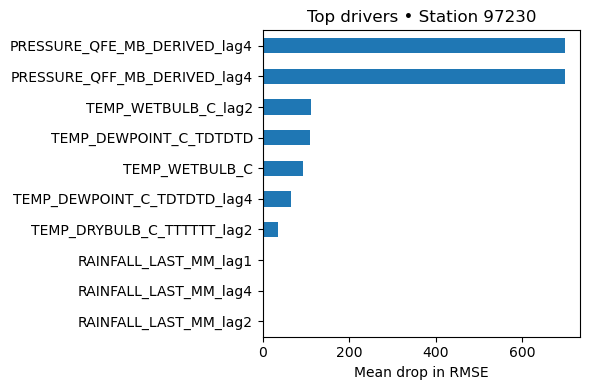

In [12]:
# ──────────────────────────────────────────────────────────────
#  Permutation importance for PSO-RBF  (uses custom RMSE scorer)
# ──────────────────────────────────────────────────────────────
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error, make_scorer
import pandas as pd, matplotlib.pyplot as plt

# robust RMSE helper already defined earlier
neg_rmse_scorer = make_scorer(
    lambda y, yhat: -rmse(y, yhat),   # negative because scorer expects “higher is better”
    greater_is_better=True)

pi = permutation_importance(
        rb_pso,
        X_te[:, mask],
        y_te,
        n_repeats=10,
        random_state=SEED,
        scoring=neg_rmse_scorer)

imp = pd.Series(pi.importances_mean, index=sel_cols)\
        .sort_values(ascending=False)

plt.figure(figsize=(6,4))
imp.head(10).plot.barh()
plt.gca().invert_yaxis()
plt.title(f"Top drivers • Station {STATION_ID}")
plt.xlabel("Mean drop in RMSE"); plt.tight_layout(); plt.show()


## Conclusions for Station {{STATION_ID}}

* **RQ1:** PSO-RBF reduced RMSE from {{RMSE_all}} → {{RMSE_PSO}}
  (DM p-value {{DM_pval}}).  
* **RQ2:** The most influential predictors were … (see bar chart).

Change **Cell 1** to the next `STATION_ID`/`DATA_FILE` and
re-run to populate the same table for the next station.


In [ ]:
final_result_df.to_csv(f'/home/rzby/airpressure_ann/ann_pressure_prediction/reports/final_result_{STATION_ID}.csv')

In [ ]:
imp.to_csv(f'/home/rzby/airpressure_ann/ann_pressure_prediction/reports/importance_{STATION_ID}.csv')